# Proyecto: El Desafío de Don Rene

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesores: Matías Rojas - Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

*Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir.*


----

## Reglas

- Fecha de entrega: 13/12/2022 (Sin atrasos)
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia. 
- Pueden usar cualquier material del curso que estimen conveniente.




# Proyecto

### Equipo:

- Camilo Carvajal Reyes
- Andrés González Fuentes

- \<Nombre de usuarios en Codalab\>

- \<Nombre del Equipo en Codalab\>

### Link de repositorio de GitHub: `https://github.com/camilocarvajalreyes/laboratorios-MDS7202`



---

## 7. Optimización del Modelo

Ahora, se procede a implementar el procesamiento de los datos para probar una combinación de diferentes parámetros a las alternativas de modelos planteadas para el problema de **regresión**, utilizando GridSearch:

**Candidatos**
- BaggingRegressor
- GradientBoostingRegressor
- RandomForestRegressor
- RegresorKNeighbors

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import re

import sys
import os
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

#### Carga y procesamiento de datos

In [ ]:
from src.features.preprocessing import Nothing, CategoriesTokenizer, boc_many_values, boc_some_values, preprocessing, custom_features

df_train = pd.read_pickle('train.pickle')
df_train = custom_features(df_train)

X_train, X_eval, y_train, y_eval = train_test_split(df_train, df_train['estimated_sells'], test_size=0.3, random_state=42)

#### Regresor Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

pipeline = Pipeline(steps = [
    ('procesamiento',preprocessing),
    ("selector", SelectPercentile(f_classif, percentile=95)),
    ("regressor",BaggingRegressor(random_state=0)),
])

In [ ]:
grilla_bagging = {
    "regressor": [BaggingRegressor(random_state=0)],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "regressor__n_estimators" : [5, 10, 15, 20],
    'regressor__max_samples' : [0.5, 0.75, 1.0],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_BR = HalvingGridSearchCV(
    pipeline,
    grilla_bagging,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 0
)

##### Entrenamiento

In [ ]:
gs_BR.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [BaggingRegressor(max_samples=0.5,
                                                               n_estimators=5,
                                                               random_state=0)],
                                'regressor__max_samples': [0.5, 0.75, 1.0],
                                'regressor__n_estimators': [5, 10, 15, 20],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=0, scoring='r2')

El mejor modelo encontrado es el siguiente

In [ ]:
gs_BR.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': BaggingRegressor(max_samples=0.5, n_estimators=5, random_state=0),
 'regressor__max_samples': 0.5,
 'regressor__n_estimators': 5,
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son:

In [ ]:
gs_BR.best_score_

-0.3984337775112237

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch Bagging Regressor")

y_pred = gs_BR.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch Bagging Regressor
Error cuadrático medio = 1234584996598.15
Score R2 = 0.07430188087615353


In [ ]:
pd.DataFrame(gs_BR.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,204,0.170311,0.003165,0.022863,0.005909,0.05,2,0.05,2,...,-1.850936,4.114507,25,0.118229,0.176843,0.150683,0.205330,0.184512,0.167120,0.030058
1,0,204,0.175379,0.003856,0.020901,0.007432,0.05,2,0.05,2,...,-1.835447,3.945499,23,0.148512,0.181553,0.154893,0.212221,0.259933,0.191422,0.040986
2,0,204,0.166538,0.016148,0.019567,0.002055,0.05,2,0.05,2,...,-1.773736,4.079435,21,0.124601,0.181263,0.167307,0.213141,0.277546,0.192772,0.051048
3,0,204,0.135035,0.021274,0.015654,0.002495,0.05,2,0.05,2,...,-1.152934,2.800538,12,0.128295,0.169033,0.187356,0.202676,0.298663,0.197205,0.056503
4,0,204,0.158373,0.017821,0.020510,0.001487,0.05,2,0.05,2,...,-7.888331,15.850940,32,0.208697,0.313081,0.272323,0.371547,0.317747,0.296679,0.054133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2,1836,1.448180,0.056548,0.032523,0.002005,0.05,2,0.05,2,...,-0.366916,1.370531,6,0.755002,0.732003,0.679016,0.648798,0.623916,0.687747,0.049294
68,2,1836,1.176931,0.185054,0.025322,0.005112,0.05,2,0.05,2,...,-0.001817,0.505873,1,0.581164,0.716948,0.577593,0.560384,0.483528,0.583923,0.075335
69,2,1836,0.783614,0.081091,0.015049,0.000720,0.05,2,0.05,2,...,-0.131457,0.706746,3,0.629815,0.687727,0.555026,0.548817,0.477021,0.579681,0.072508
70,3,5508,3.203425,0.249444,0.028181,0.001108,0.05,2,0.05,2,...,-0.398434,0.741954,7,0.577815,0.629193,0.734570,0.637756,0.666973,0.649261,0.051441


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_BR.cv_results_)['mean_test_score'].max()

-0.0018171004320974404

Distribución de puntajes de test promedio

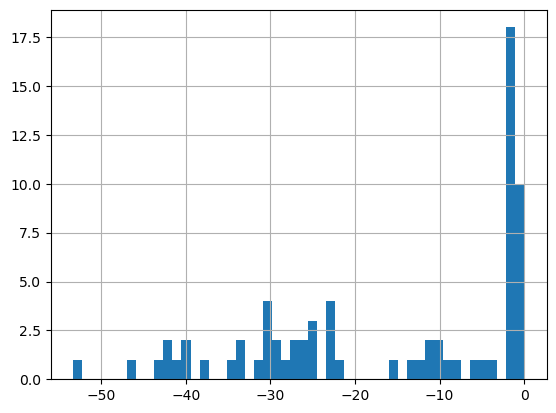

In [ ]:
pd.DataFrame(gs_BR.cv_results_)['mean_test_score'].hist(bins=50);

#### Regresor GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grilla_GB = {
    "regressor": [GradientBoostingRegressor(random_state=0)],
    "regressor__n_estimators" :[25, 50, 100, 250, 500],
    "regressor__learning_rate" : [0.05, 0.1, 0.2],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_GB = HalvingGridSearchCV(
    pipeline,
    grilla_GB,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

##### Entrenamiento

In [ ]:
gs_GB.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [GradientBoostingRegressor(n_estimators=25,
                                                                        random_state=0)],
                                'regressor__learning_rate': [0.05, 0.1, 0.2],
                                'regressor__n_estimators': [25, 50, 100, 250,
                                                            500],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es el siguiente

In [ ]:
gs_GB.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': GradientBoostingRegressor(n_estimators=25, random_state=0),
 'regressor__learning_rate': 0.1,
 'regressor__n_estimators': 25,
 'selector__percentile': 75,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son

In [ ]:
gs_GB.best_score_

0.3022064603413524

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch GradienBoosting Regressor")

y_pred = gs_GB.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch GradienBoosting Regressor
Error cuadrático medio = 1399797568491.39
Score R2 = -0.04957534708190314


Resultados generales del gridsearch

In [ ]:
pd.DataFrame(gs_GB.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,204,0.130810,0.024000,0.018134,0.002322,0.05,2,0.05,2,...,-0.385086,0.564285,7,0.817746,0.770992,0.808212,0.855576,0.818540,0.814213,0.027004
1,0,204,0.167412,0.006141,0.015954,0.002003,0.05,2,0.05,2,...,-0.321237,0.510603,6,0.820785,0.777659,0.809769,0.868919,0.818540,0.819134,0.029290
2,0,204,0.151374,0.015460,0.016514,0.000984,0.05,2,0.05,2,...,-0.392055,0.562364,8,0.819266,0.777659,0.812299,0.868919,0.818540,0.819337,0.029140
3,0,204,0.139000,0.012924,0.015647,0.001699,0.05,2,0.05,2,...,-0.450097,0.656235,9,0.819266,0.777659,0.812299,0.868919,0.818540,0.819337,0.029140
4,0,204,0.171243,0.011200,0.016189,0.002655,0.05,2,0.05,2,...,-0.591970,0.822121,15,0.922369,0.911209,0.923507,0.955613,0.918691,0.926278,0.015285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2,1836,1.256325,0.023807,0.024848,0.004276,0.05,2,0.05,2,...,-0.204805,0.746390,4,0.837328,0.830131,0.828975,0.827379,0.685352,0.801833,0.058340
86,2,1836,1.013528,0.127757,0.016665,0.004447,0.05,2,0.05,2,...,-0.248864,0.812608,5,0.837328,0.830131,0.828975,0.827379,0.685352,0.801833,0.058340
87,3,5508,3.202963,0.098917,0.056693,0.004471,0.05,2,0.05,2,...,0.302206,0.106159,1,0.888144,0.779213,0.865642,0.887081,0.864194,0.856855,0.040130
88,3,5508,3.382027,0.076082,0.062297,0.013062,0.05,2,0.05,2,...,0.252176,0.101433,3,0.777289,0.652265,0.744576,0.766345,0.757564,0.739608,0.044968


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_GB.cv_results_)['mean_test_score'].max()

0.3022064603413524

Distribución de puntajes de test promedio

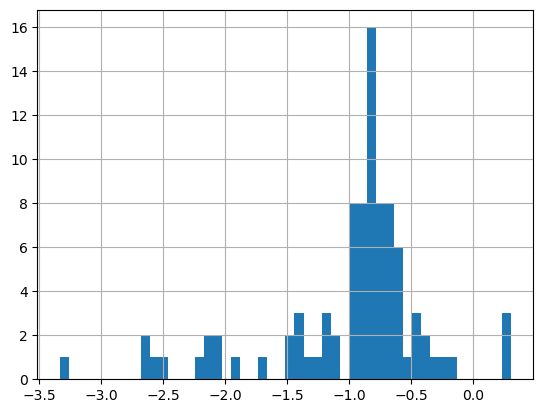

In [ ]:
pd.DataFrame(gs_GB.cv_results_)['mean_test_score'].hist(bins=50);

#### Regresor RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

grilla_RF = {
    "regressor": [RandomForestRegressor(random_state=0)],
    "regressor__n_estimators" :[25, 50, 100, 250, 500],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_RF = HalvingGridSearchCV(
    pipeline,
    grilla_RF,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

##### Entrenamiento

In [ ]:
gs_RF.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-genres__min_df': [0.05],
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [RandomForestRegressor(n_estimators=250,
                                                                    random_state=0)],
                                'regressor__n_estimators': [25, 50, 100, 250,
                                                            500],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es este

In [ ]:
gs_RF.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': RandomForestRegressor(n_estimators=250, random_state=0),
 'regressor__n_estimators': 250,
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son

In [ ]:
gs_RF.best_score_

0.13916797488476115

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch RandomForest Regressor")

y_pred = gs_RF.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch RandomForest Regressor
Error cuadrático medio = 1167737330168.9788
Score R2 = 0.12442460167043812


Resultados generales del gridsearch

In [ ]:
pd.DataFrame(gs_RF.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,612,0.644662,0.035886,0.021523,0.001870,0.05,2,0.05,2,...,-1.247978,2.402642,16,0.857624,0.724348,0.780633,0.785990,0.836318,0.796983,0.046666
1,0,612,0.736613,0.036244,0.022719,0.001556,0.05,2,0.05,2,...,-1.368112,2.893105,19,0.898200,0.726873,0.781512,0.779396,0.838395,0.804875,0.058502
2,0,612,0.776128,0.029057,0.023288,0.002545,0.05,2,0.05,2,...,-1.034241,2.180536,12,0.887430,0.720090,0.784616,0.794354,0.829295,0.803157,0.054966
3,0,612,0.771858,0.044191,0.022652,0.001490,0.05,2,0.05,2,...,-0.866795,1.826811,11,0.893534,0.715535,0.776626,0.787111,0.844417,0.803445,0.060842
4,0,612,0.914836,0.037203,0.027652,0.002522,0.05,2,0.05,2,...,-2.272117,4.596407,30,0.870051,0.737248,0.867950,0.871253,0.856128,0.840526,0.051919
5,0,612,1.161152,0.071643,0.030959,0.004451,0.05,2,0.05,2,...,-2.225709,4.652668,28,0.896091,0.753960,0.871120,0.868970,0.852661,0.848560,0.049297
6,0,612,1.275476,0.090421,0.034585,0.013454,0.05,2,0.05,2,...,-2.235161,4.668620,29,0.887593,0.747315,0.872662,0.871989,0.850346,0.845981,0.050742
7,0,612,1.386598,0.243654,0.026355,0.002177,0.05,2,0.05,2,...,-1.912604,3.956573,26,0.892674,0.730113,0.869569,0.870150,0.853841,0.843269,0.057916
8,0,612,1.887039,0.220927,0.037261,0.005059,0.05,2,0.05,2,...,-1.920895,3.959903,27,0.874885,0.743629,0.834866,0.837960,0.860050,0.830278,0.045748
9,0,612,2.261686,0.254103,0.036975,0.005271,0.05,2,0.05,2,...,-1.692584,3.629238,23,0.892882,0.748505,0.838299,0.837938,0.854882,0.834501,0.047424


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].max()

0.13916797488476115

Distribución de puntajes de test promedio

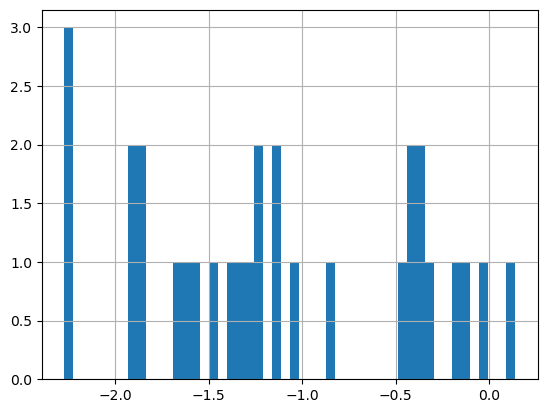

In [ ]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].hist(bins=50);

#### Regresor KNeighbours

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

grilla_KN = {
    "regressor": [KNeighborsRegressor()],
    "regressor__n_neighbors" :[3, 5, 10],
    "regressor__weights" : ['uniform', 'distance'],
    "regressor__metric" :['euclidean'],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_KN = HalvingGridSearchCV(
    pipeline,
    grilla_KN,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

##### Entrenamiento

In [ ]:
gs_KN.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [KNeighborsRegressor(metric='euclidean',
                                                                  weights='distance')],
                                'regressor__metric': ['euclidean'],
                                'regressor__n_neighbors': [3, 5, 10],
                                'regressor__weights': ['uniform', 'distance'],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es:

In [ ]:
gs_KN.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': KNeighborsRegressor(metric='euclidean', weights='distance'),
 'regressor__metric': 'euclidean',
 'regressor__n_neighbors': 5,
 'regressor__weights': 'distance',
 'selector__percentile': 95,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus resultados son

In [ ]:
gs_KN.best_score_

0.18841414367272324

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch k-Neighbors Regressor")

y_pred = gs_KN.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch k-Neighbors Regressor
Error cuadrático medio = 1284238152349.843
Score R2 = 0.03707169177248115


Resultados generales del gridsearch:

In [ ]:
pd.DataFrame(gs_KN.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,612,0.355671,0.044404,0.030705,0.010335,0.05,2,0.05,2,...,-0.006143,0.149574,35,0.539736,0.559631,0.566475,0.577115,0.529482,0.554488,1.746439e-02
1,0,612,0.432875,0.030356,0.025684,0.000581,0.05,2,0.05,2,...,0.013198,0.155283,33,0.526897,0.567087,0.578250,0.575452,0.561844,0.561906,1.845607e-02
2,0,612,0.418662,0.033104,0.027304,0.003249,0.05,2,0.05,2,...,0.088962,0.239714,19,0.522651,0.572077,0.576088,0.576254,0.533884,0.556191,2.312260e-02
3,0,612,0.402116,0.018684,0.023699,0.001295,0.05,2,0.05,2,...,0.088739,0.240007,20,0.521720,0.572078,0.575315,0.576226,0.533591,0.555786,2.331416e-02
4,0,612,0.455759,0.040366,0.023403,0.001496,0.05,2,0.05,2,...,-0.004586,0.150080,34,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,0,612,0.411033,0.023850,0.024445,0.002397,0.05,2,0.05,2,...,0.016519,0.145093,32,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
6,0,612,0.425403,0.030147,0.026112,0.005084,0.05,2,0.05,2,...,0.090342,0.230441,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
7,0,612,0.393863,0.017287,0.023203,0.001296,0.05,2,0.05,2,...,0.090418,0.231226,16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,0,612,0.398357,0.030994,0.023108,0.001405,0.05,2,0.05,2,...,0.020451,0.084547,31,0.393729,0.387034,0.388233,0.373486,0.394827,0.387462,7.610865e-03
9,0,612,0.395113,0.024384,0.022951,0.000877,0.05,2,0.05,2,...,0.071350,0.102129,25,0.491158,0.387970,0.385834,0.375660,0.374929,0.403110,4.433467e-02


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].max()

0.18841414367272324

Distribución de puntajes de test promedio

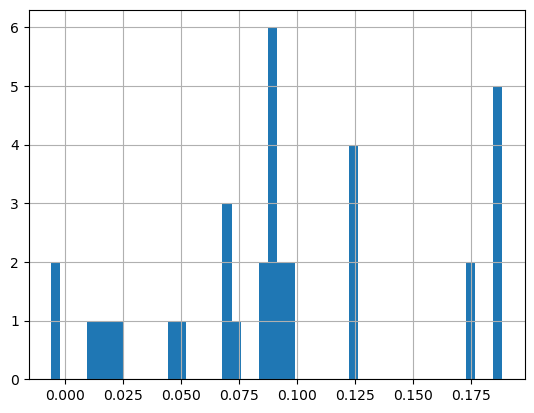

In [ ]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].hist(bins=50);

#### Regresor Support Vector

In [ ]:
from sklearn.svm import SVR

grilla_SV = {
    "regressor": [SVR()],
    "regressor__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "regressor__C":[1.,100.,1000.],
    "regressor__epsilon" : [0.05, 0.1, 0.2],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_SV = HalvingGridSearchCV(
    pipeline,
    grilla_SV,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 0
)

##### Entrenamiento

In [ ]:
gs_SV.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [SVR(C=100.0, epsilon=0.05,
                                                  kernel='linear')],
                                'regressor__C': [1.0, 100.0, 1000.0],
                                'regressor__epsilon': [0.05, 0.1, 0.2],
                                'regressor__kernel': ['linear', 'poly', 'rbf',
                                                      'sigmoid'],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=0, scoring='r2')

El mejor modelo encontrado es

In [ ]:
gs_SV.best_params_

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': SVR(C=100.0, epsilon=0.05, kernel='linear'),
 'regressor__C': 100.0,
 'regressor__epsilon': 0.05,
 'regressor__kernel': 'linear',
 'selector__percentile': 95,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus resultados son:

In [ ]:
gs_SV.best_score_

-0.004749885773132156

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch SupportVector Regressor")

y_pred = gs_SV.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch SupportVector Regressor
Error cuadrático medio = 1339576402869.6592
Score R2 = -0.004421210346814419


Resultados generales del gridsearch

In [ ]:
pd.DataFrame(gs_SV.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,68,0.010967,0.013271,0.001643,0.003286,0.05,2,0.05,2,...,NaN,NaN,109,NaN,-0.120656,NaN,NaN,NaN,NaN,NaN
1,0,68,0.013183,0.015019,0.002605,0.005211,0.05,2,0.05,2,...,NaN,NaN,138,NaN,-0.120654,NaN,NaN,NaN,NaN,NaN
2,0,68,0.012260,0.013244,0.001645,0.003290,0.05,2,0.05,2,...,NaN,NaN,139,NaN,-0.120648,NaN,NaN,NaN,NaN,NaN
3,0,68,0.019885,0.015237,0.002123,0.004247,0.05,2,0.05,2,...,NaN,NaN,140,NaN,-0.120524,NaN,NaN,NaN,NaN,NaN
4,0,68,0.013540,0.012186,0.001679,0.003358,0.05,2,0.05,2,...,NaN,NaN,141,NaN,-0.120680,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,3,1836,1.514560,0.050592,0.106708,0.006559,0.05,2,0.05,2,...,-0.005598,0.017302,4,-0.005360,-0.011731,-0.010519,-0.009469,-0.009060,-0.009228,0.002144
212,3,1836,1.465177,0.201438,0.102866,0.017435,0.05,2,0.05,2,...,-0.005599,0.017300,5,-0.005360,-0.011731,-0.010519,-0.009469,-0.009060,-0.009228,0.002144
213,3,1836,0.960544,0.071712,0.069408,0.002413,0.05,2,0.05,2,...,-0.005599,0.017300,6,-0.005360,-0.011731,-0.010519,-0.009469,-0.009060,-0.009228,0.002144
214,4,5508,6.980818,0.412546,1.100019,0.048239,0.05,2,0.05,2,...,-0.004750,0.003731,2,-0.003484,-0.005716,-0.004714,-0.004469,-0.003036,-0.004284,0.000945


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].max()

-0.004749885773132156

Distribución de puntajes de test promedio

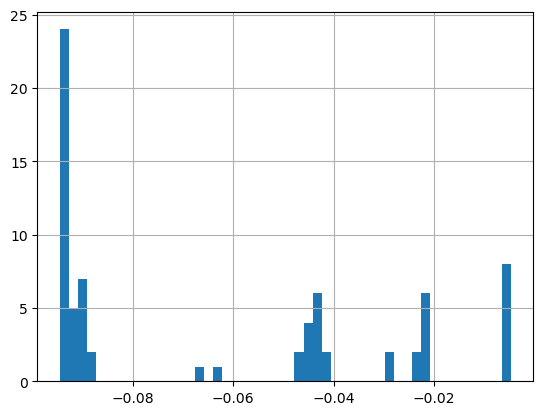

In [ ]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].hist(bins=50);

#### Regresores lineales

In [ ]:
from sklearn.linear_model import ElasticNet, Ridge

grilla_lineal = {
    "regressor": [ElasticNet(random_state=0),Ridge(random_state=0)],
    "regressor__alpha": [0.75, 1, 1.25, 1.5],
    "regressor__tol": [5e-3, 1e-4, 5e-5],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_lineal = HalvingGridSearchCV(
    pipeline,
    grilla_lineal,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 0
)

##### Entrenamiento

In [ ]:
gs_lineal.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'regressor': [ElasticNet(alpha=1.5,
                                                         random_state=0),
                                              Ridge(random_state=0)],
                                'regressor__alpha': [0.75, 1, 1.25, 1.5],
                                'regressor__tol': [0.005, 0.0001, 5e-05],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=0, scoring='r2')

Mejor modelo encontrado

In [ ]:
gs_lineal.best_params_

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 2,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': ElasticNet(alpha=1.5, random_state=0),
 'regressor__alpha': 1.5,
 'regressor__tol': 0.0001,
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

y sus resultados son

In [ ]:
gs_lineal.best_score_

0.07717714273270082

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch SupportVector Regressor")

y_pred = gs_lineal.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch SupportVector Regressor
Error cuadrático medio = 1248738493745.036
Score R2 = 0.06368951662095934


Resultados generales del gridsearch

In [ ]:
pd.DataFrame(gs_lineal.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,68,0.011335,0.012603,0.001468,0.002937,0.05,2,0.05,2,...,NaN,NaN,73,NaN,0.266156,NaN,NaN,NaN,NaN,NaN
1,0,68,0.012731,0.014870,0.002326,0.004653,0.05,2,0.05,2,...,NaN,NaN,93,NaN,0.283629,NaN,NaN,NaN,NaN,NaN
2,0,68,0.015587,0.016666,0.001653,0.003306,0.05,2,0.05,2,...,NaN,NaN,94,NaN,0.308795,NaN,NaN,NaN,NaN,NaN
3,0,68,0.012560,0.013833,0.001809,0.003619,0.05,2,0.05,2,...,NaN,NaN,95,NaN,0.389166,NaN,NaN,NaN,NaN,NaN
4,0,68,0.012456,0.013870,0.001744,0.003487,0.05,2,0.05,2,...,NaN,NaN,96,NaN,0.266156,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,3,1836,1.155612,0.065015,0.031262,0.006425,0.05,2,0.05,2,...,-0.001031,0.206738,5,0.058318,0.085058,0.077310,0.079018,0.079314,0.075804,0.009125
141,3,1836,0.948995,0.158223,0.019355,0.005634,0.05,2,0.05,2,...,-0.001028,0.206740,4,0.058320,0.085060,0.077312,0.079021,0.079317,0.075806,0.009125
142,3,1836,0.819386,0.096081,0.013591,0.001155,0.05,2,0.05,2,...,-0.001028,0.206740,3,0.058320,0.085060,0.077312,0.079021,0.079317,0.075806,0.009125
143,4,5508,2.454077,0.232542,0.044461,0.008348,0.05,2,0.05,2,...,0.077177,0.041246,2,0.043671,0.066799,0.049014,0.049508,0.043420,0.050482,0.008551


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_lineal.cv_results_)['mean_test_score'].max()

0.07717714273270082

Distribución de puntajes de test promedio

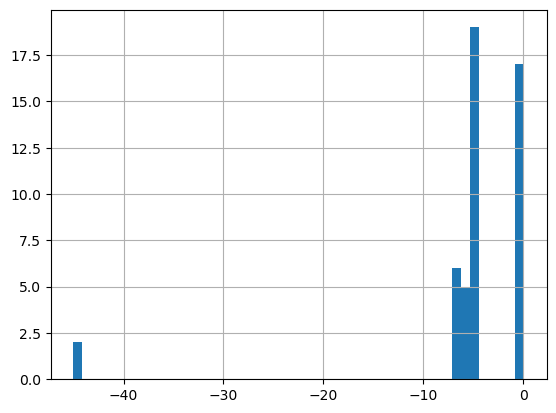

In [ ]:
pd.DataFrame(gs_lineal.cv_results_)['mean_test_score'].hist(bins=50);

#### Multi-layer perceptron

In [ ]:
from sklearn.neural_network import MLPRegressor

grilla_MLP = {
    "regressor": [MLPRegressor(random_state=0)],
    "regressor__hidden_layer_sizes":[(50,),(100,),(200,),(100,50,),(200,100,),(200,50,)],
    "regressor__solver" : ['sgd', 'adam'],
    "regressor__learning_rate" : ['constant', 'invscaling', 'adaptive'],
    "regressor__learning_rate_init" : [0.1,0.01,0.001,0.0001],
    "selector__percentile": [90, 95, 100],
    "selector__score_func":[f_classif],
    "procesamiento__BoC-cat__min_df" : [0.02],
    "procesamiento__BoC-genres__min_df" : [0.02],
    "procesamiento__BoC-tags__min_df" : [0.02],
    "procesamiento__BoC-dev__min_df" : [1],
    "procesamiento__BoC-pub__min_df" : [1],
}

gs_MLP = HalvingGridSearchCV(
    pipeline,
    grilla_MLP,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 0,
    error_score = -100
)

##### Entrenamiento

In [ ]:
gs_MLP.fit(X_train, y_train)

HalvingGridSearchCV(error_score=-100,
                    estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7f53df139d20>),
                                                                                'categor...
                                'regressor__hidden_layer_sizes': [(50,), (100,),
                                                                  (200,),
                                                                  (100, 50),
                                                                  (200, 100),
                                                                  (200, 50)],
                                'regressor__learning_rate': ['constant',
                                                             'invscaling',
                                                             'adaptive'],
                                'regressor__learning_rate_init': [0.1, 0.01,
                                                                  0.001,
                                                                  0.0001],
                                'regressor__solver': ['sgd', 'adam'],
                                'selector__percentile': [90, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f53edd5f2e0>]},
                    random_state=0, scoring='r2')

El mejor modelo encontrado es el siguiente

In [ ]:
gs_MLP.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.02,
 'procesamiento__BoC-dev__min_df': 1,
 'procesamiento__BoC-genres__min_df': 0.02,
 'procesamiento__BoC-pub__min_df': 1,
 'procesamiento__BoC-tags__min_df': 0.02,
 'regressor': MLPRegressor(hidden_layer_sizes=(200, 100), learning_rate='invscaling',
              random_state=0),
 'regressor__hidden_layer_sizes': (200, 100),
 'regressor__learning_rate': 'invscaling',
 'regressor__learning_rate_init': 0.001,
 'regressor__solver': 'adam',
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

y sus métricas son

In [ ]:
gs_MLP.best_score_

0.14885355109901247

##### Resultados

In [ ]:
print("Resultados clasificador ganador de GridSearch MLP Regressor")

y_pred = gs_MLP.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch MLP Regressor
Error cuadrático medio = 1147160333594.7087
Score R2 = 0.13985333851602266


Resultados generales del grid-search

In [ ]:
pd.DataFrame(gs_MLP.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,22,0.138738,0.026737,0.017358,0.001921,0.02,1,0.02,1,...,-1.154086e+10,2.306741e+10,514,-59254.153297,-426178.971220,-115845.523144,-5.931351e+05,-1.329098e+06,-5.047023e+05,4.567817e+05
1,0,22,0.120601,0.020719,0.017102,0.003912,0.02,1,0.02,1,...,-2.502894e+10,4.998505e+10,515,-361044.423678,-124329.832686,-208879.146483,-3.881120e+06,-2.881110e+06,-1.491297e+06,1.576928e+06
2,0,22,0.074385,0.030445,0.019492,0.006848,0.02,1,0.02,1,...,-3.549656e+10,7.080830e+10,518,-944137.588850,-421848.249880,-365720.748377,-4.838366e+06,-4.082572e+06,-2.130529e+06,1.927927e+06
3,0,22,0.215905,0.007742,0.017354,0.003392,0.02,1,0.02,1,...,-1.630877e+02,3.114020e+02,380,0.376133,0.626754,0.638206,1.098260e-01,9.205116e-02,3.685940e-01,2.378364e-01
4,0,22,0.238474,0.013443,0.020081,0.002075,0.02,1,0.02,1,...,-2.083875e+02,3.990070e+02,390,0.515571,0.505656,0.547746,1.776149e-01,1.447393e-01,3.782654e-01,1.781010e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,4,1782,192.187174,3.311570,0.088644,0.040564,0.02,1,0.02,1,...,-5.765406e-02,2.549289e-01,22,0.027988,0.084521,0.074719,6.261038e-02,8.671254e-02,6.731023e-02,2.142822e-02
644,4,1782,170.847747,40.544218,0.059328,0.019038,0.02,1,0.02,1,...,-5.765406e-02,2.549289e-01,22,0.027988,0.084521,0.074719,6.261038e-02,8.671254e-02,6.731023e-02,2.142822e-02
645,4,1782,86.101215,1.757317,0.019219,0.005450,0.02,1,0.02,1,...,-5.765406e-02,2.549289e-01,22,0.027988,0.084521,0.074719,6.261038e-02,8.671254e-02,6.731023e-02,2.142822e-02
646,5,5346,1060.695461,5.730701,0.084711,0.040044,0.02,1,0.02,1,...,1.488536e-01,8.702981e-02,1,0.132868,0.254319,0.172845,1.886839e-01,1.354949e-01,1.768422e-01,4.427693e-02


Mejor puntaje de test promedio

In [ ]:
pd.DataFrame(gs_MLP.cv_results_)['mean_test_score'].max()

0.14885355109901247

**Resumen**

| Modelo | **R2 CV GridSearch** |
|:---:|:---:|
| **ElasticNet** (baseline) | **0.07** |
| **LinealSVR** | **0.00** |
| **KNeighborsRegressor** | **0.18** |
| **RandomForestRegressor** | **0.13** |
| **BaggingRegressor** | **-0.39** |
| **GradientBoosting** | **0.30** |
| **MLPRegressor** | **0.14** |
| **VotingRegressor** | - |

Pudimos ver que mejor modelo mejora/no mejora los resultados obtenidos en el baseline.


Para la tarea de regresión la búsqueda de grilla nos dió preocupantes resultados para muchos de los métodos. Los resultados para los métodos lineales se mantuvieron cercanos a 0. El modelo de k-vecinos no mejoró al variar los parámetros. Pero sobretodo, los modelos de tipo emsemble mostraron una brusca disminución en su R2 promedio. Nuestra hipótesis al respecto es que la gran variabilidad en las distintas particiones así como la sensibilidad de la métrica R2 hicieron que los resultados fuesen excesivamente variados, lo cual dificulta concluir si un modelo es mejor o no que otro.

Si bien para Random Forest se obtuvo un mejor valor de Gridsearch alto, para el resto de los modelos los valores fueron muy bajos. Más aún, al graficar los distintos puntajes obtenidos en histogramas se nota una nula agrupación. Esto nos dice que no hay realmente patrones que se estén encontrando en cuanto a combinación de parámetros. Pese a lo anterior, nos quedamos con los mejores modelos promedio para la siguiente etapa de evaluación.